In [5]:
import os
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import matplotlib
#from matplotlib.backends.backend_pdf import PdfPages
#import seaborn as sns
#import statsmodels.api as sm

#lowess = sm.nonparametric.lowess
from tqdm import tqdm 
import sys

sys.path.append('/private/groups/shapirolab/brock/Software')
from py3_functions import *

from IPython.display import display

!mkdir -p /private/groups/shapirolab/brock/mutation
os.chdir('/private/groups/shapirolab/brock/mutation')
!mkdir -p cmds logs

### R stuff
from rpy2 import rinterface
#from jupyter_helpers import rpy2_autocompletion
%load_ext rpy2.ipython

samples = []
with open('poplists/samples.txt') as infile:
    for line in infile:
        line = line.strip()
        samples.append(line)
infile.close()

species = []
with open('poplists/phylo_species.txt') as infile:
    for line in infile:
        line = line.strip()
        species.append(line)
infile.close()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
%%R
library(tidyverse)
library(ggplot2)
library(magrittr)
library(data.table)
library(ggtree)

# Download data

## Assemblies

In [36]:
!mkdir -p downloads
with open('poplists/phylo_asm.txt','r') as infile:
    for line in infile:
        line = line.strip()
        species, ASM = line.split('\t')
        cmd = f"datasets download genome accession {ASM} --include gff3,rna,cds,protein,genome,seq-report --filename downloads/{species}.zip;unzip downloads/{species}.zip"
        print(cmd)
infile.close()

datasets download genome accession GCA_037392515.1 --include gff3,rna,cds,protein,genome,seq-report --filename downloads/asinina.zip;unzip downloads/asinina.zip
datasets download genome accession GCF_023055435.1 --include gff3,rna,cds,protein,genome,seq-report --filename downloads/rufescens.zip;unzip downloads/rufescens.zip
datasets download genome accession GCF_003918875.1 --include gff3,rna,cds,protein,genome,seq-report --filename downloads/rubra.zip;unzip downloads/rubra.zip
datasets download genome accession GCA_022045235.1 --include gff3,rna,cds,protein,genome,seq-report --filename downloads/cracherodii.zip;unzip downloads/cracherodii.zip
datasets download genome accession GCA_008038995.1 --include gff3,rna,cds,protein,genome,seq-report --filename downloads/laevigata.zip;unzip downloads/laevigata.zip
datasets download genome accession GCA_936450465.1 --include gff3,rna,cds,protein,genome,seq-report --filename downloads/magus.zip;unzip downloads/magus.zip


# BUSCO

In [8]:
!mkdir -p BUSCO
for COMMON in species:
    !mkdir -p BUSCO/$COMMON
    asm = f"assembly/{COMMON}.fa"
    busco = f"BUSCO/{COMMON}/summary.txt"
    if not os.path.exists(asm): continue
    if os.path.exists(busco): continue
    cmd = ('''compleasm run -a {asm} -l mollusca_odb10 -L mb_downloads --t 8 -o BUSCO/{COMMON} > logs/{COMMON}.busco.out 2>&1\n''').format(asm = asm, COMMON = COMMON)
    slurm = make_slurm(run = False, p = 'long', id = f"{COMMON}.busco", cmd_string = cmd, c = '8', mem = '40000',time = '24:00:00')

# Tree construction

In [9]:
%%R
fs = list.files('BUSCO', pattern='*full_table.tsv*', recursive = T, full.names = T)
full = bind_rows(lapply(fs,function(PATH){fread(PATH) %>% mutate(path = PATH)}))
full %<>% mutate(species = gsub('BUSCO/','',path) %>% gsub('/.*$','',.))

Select loci

In [48]:
%%R
keep_1 = 
    full %>% filter(Status == 'Single') %>%
    group_by(Gene) %>% 
    summarize(count = n()) %>% 
    filter(count >= 7) %>% 
    pull(Gene) %>%
    unique
full %>% 
    filter(Gene %in% keep_1) %>%
    dplyr::select(Sequence,`Gene Start`,`Gene End`,Strand,species,Gene,`Best gene`) %>%
    fwrite('phylo/busco_keep.txt',sep="\t",col.names=F,row.names=F)

Grab sequences

In [54]:
!mkdir -p phylo/seqs
out_cmd_file = open('cmds/seq_grab.txt','w')

with open('phylo/busco_keep.txt','r') as infile:
    for line in infile:
        line = line.strip()
        chrom, start, end, strand, species, gene, best_gene = line.split('\t')
        cmd = f"gffread -x - -g assembly/{species}.fa <(grep '\\<{best_gene}\\>' BUSCO/{species}/mollusca_odb10/miniprot_output.gff | grep 'CDS') | sed 's|>.*$|>{species}|' >> phylo/seqs/{gene}.fasta\n"
        out_cmd_file.write(cmd)
infile.close()
out_cmd_file.close()

Alignment

In [112]:
import pandas as pd
out_cmd_file = open('cmds/aln.txt','w')
genes = list(set(pd.read_csv('phylo/busco_keep.txt',sep="\t",header=None)[5].to_list()))
for GENE in genes:
    cmd = f"mafft phylo/seqs/{GENE}.fasta > phylo/seqs/{GENE}_aln.fasta\n"
    out_cmd_file.write(cmd)
out_cmd_file.close()

Code to extract 4-fold degenerate sites

In [132]:
%%writefile ./fourfold.py

from Bio import AlignIO
from Bio.Seq import Seq
from Bio.Data import CodonTable
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
import argparse
parser = argparse.ArgumentParser(description='Write alignment of just fourfold degenerate sites')
parser.add_argument('input', metavar='I', type=str,
                    help='input fasta alignment ')
parser.add_argument('output', metavar='O', type=str,
                    help='output fasta alignment of fourfold deg. sites ')
args = parser.parse_args()

def get_codon_positions(sequence):
    """Split a nucleotide sequence into codons."""
    return [sequence[i:i+3] for i in range(0, len(sequence), 3)]

def is_fourfold_degenerate(codon, pos, codon_table):
    """Check if the position in the codon is fourfold degenerate."""
    if codon in codon_table.stop_codons:
        return False
    amino_acid = codon_table.forward_table.get(codon, '')
    if pos == 0 or pos == 1:  # First and second positions cannot be fourfold degenerate
        return False
    if pos == 2:  # Check third position
        bases = ['A', 'T', 'C', 'G']
        variants = [codon[:2] + base for base in bases]
        return all([codon_table.forward_table.get(var, '') == amino_acid for var in variants])

## Load the alignment
alignment = AlignIO.read(args.input, "fasta")

# Define the standard codon table
standard_table = CodonTable.unambiguous_dna_by_id[1]

# Iterate over each codon position in the first sequence (assuming alignment)
sequence_length = alignment.get_alignment_length()
fourfold_degenerate_sites = []

for i in range(0, sequence_length, 3):
    codons = [str(record.seq[i:i+3]) for record in alignment]
    if len(codons[0]) != 3:
        continue  # Skip incomplete codons
    for pos in range(3):
        if is_fourfold_degenerate(codons[0].upper(), pos, standard_table):
            fourfold_degenerate_sites.append(i + pos)

# Create new alignment
new_records = []
for record in alignment:
    new_seq = "".join([record.seq[pos - 1] for pos in fourfold_degenerate_sites])
    new_record = SeqRecord(Seq(new_seq), id=record.id, description="")
    new_records.append(new_record)
new_alignment = MultipleSeqAlignment(new_records)

# Write to file
with open(args.output, "w") as output_handle:
    AlignIO.write(new_alignment, output_handle, "fasta")


Overwriting ./fourfold.py


Execute

In [136]:
import pandas as pd
out_cmd_file = open('cmds/4f.txt','w')
genes = list(set(pd.read_csv('phylo/busco_keep.txt',sep="\t",header=None)[5].to_list()))
for GENE in genes:
    cmd = f"python fourfold.py phylo/seqs/{GENE}_aln.fasta phylo/seqs/{GENE}_4f.fasta\n"
    out_cmd_file.write(cmd)
out_cmd_file.close()

Trim

4f sequences

In [80]:
import pandas as pd
out_cmd_file = open('cmds/trimal.txt','w')
genes = list(set(pd.read_csv('phylo/busco_keep.txt',sep="\t",header=None)[5].to_list()))
for GENE in genes:
    cmd = f"trimal -in phylo/seqs/{GENE}_4f.fasta -gt 0.50 -cons 50 -keepheader -fasta -out phylo/seqs/{GENE}_4f_trimmed.fasta\n"
    out_cmd_file.write(cmd)
out_cmd_file.close()



Original ones incase I need them:

In [81]:
import pandas as pd
out_cmd_file = open('cmds/trimal.txt','w')
genes = list(set(pd.read_csv('phylo/busco_keep.txt',sep="\t",header=None)[5].to_list()))
for GENE in genes:
    cmd = f"trimal -in phylo/seqs/{GENE}_aln.fasta -gt 0.50 -cons 50 -keepheader -fasta -out phylo/seqs/{GENE}_aln_trimmed.fasta\n"
    out_cmd_file.write(cmd)
out_cmd_file.close()


Do some quick QC to get lengths of genes and # taxa (i.e. are duplicates present).

In [ ]:
%%bash
ls phylo/seqs/*trimmed*fasta | sed "s/^/samtools faidx /g" | parallel --progress --jobs 64

In [92]:
%%R
fs = list.files('phylo/seqs/',pattern = '*.trimmed.*.fai.*', full.names = T)
FAIread = function(PATH){
    fai = 
        fread(PATH) %>% 
        mutate(source = basename(PATH) %>% gsub('_trimmed.fasta.fai','',.)) %>% 
        mutate(GENE = gsub('_.*','',source), type = gsub('.*_','',source)) %>%
        set_colnames(c('species','length','total','a','b','source','GENE','type'))
    return(fai)     
}
stats = bind_rows(lapply(fs,FAIread))

stats %>%
    filter(type == '4f') %>%
    filter(length > 300) %>%
    group_by(GENE) %>%
    summarize(count = n()) %>%
    filter(count == 7) %>%
    ungroup %>%
    dplyr::select(GENE) %>%
    distinct %>%
    fwrite('phylo/4f_good_genes.txt')

stats %>%
    filter(type == 'aln') %>%
    filter(length > 900) %>%
    group_by(GENE) %>%
    summarize(count = n()) %>%
    filter(count == 7) %>%
    ungroup %>%
    dplyr::select(GENE) %>%
    distinct %>%
    fwrite('phylo/aln_good_genes.txt')

Concatenate with seqkit. Before I do this, I need to make sure that all sequences in an alignment have the same length. In theory they should be, but somehow that's not occurring because of duplicate species.

In [224]:
%%capture
import pandas as pd
import subprocess
!mkdir -p phylo/keep/
genes = list(set(pd.read_csv('phylo/busco_keep.txt',sep="\t",header=None)[5].to_list()))
for GENE in genes:
    lengths = pd.read_csv(f"phylo/seqs/{GENE}_4f_trimmed.fasta.fai",sep="\t",header=None)[1].to_list()
    seqs = subprocess.run(f"grep -c '>' phylo/seqs/{GENE}_4f_trimmed.fasta ", shell = True, stdout=subprocess.PIPE)
    if seqs.stdout.strip().decode() == '7':
        if len(set(lengths)) == 1:
            cp = subprocess.run(f"cp phylo/seqs/{GENE}_4f_trimmed.fasta phylo/keep/ ", shell = True, stdout=subprocess.PIPE)
cmd = "seqkit concat phylo/keep/*fasta > phylo/all_4f.fasta;samtools faidx phylo/all_4f.fasta"
!$cmd 

Now, pipe in alignment to iqtree

In [229]:
cmd = ('''iqtree -s phylo/all_4f.fasta -bb 1000 -bnni -m MFP -nt 16 ''')
slurm = make_slurm(run = False, p = 'long', id = "iqtree", cmd_string = cmd, mem = '40000', time = '24:00:00', c = 16)

Submitted batch job 3860668


## Results

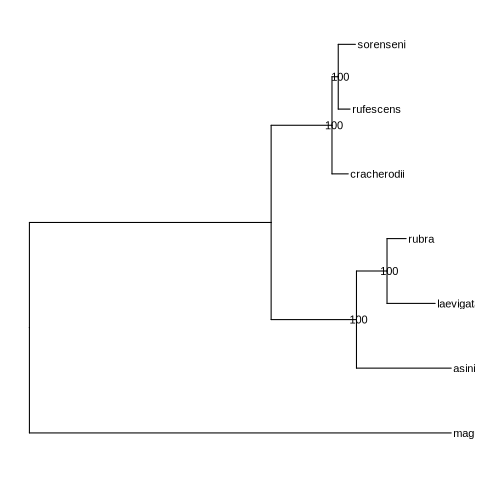

In [21]:
%%R
library(ggtree)
library(ape)
library(phytools)
tr = read.tree('phylo/all_4f.fasta.treefile')
tr = phytools::midpoint.root(tr,'magus')
p = 
    ggtree(tr) +
    geom_tiplab() +
    geom_nodelab()
print(p)
tr$edge.length = NULL
tr$node.label = NULL
write.tree(tr,'BPP/cladogram.nwk')

# Divergence time estimation

## Clock-like genes

Full genes

In [7]:
genes = []
with open('phylo/aln_good_genes.txt','r') as infile:
    for line in infile:
        line = line.strip('\n')
        genes.append(line)
infile.close()

parfile = open(f"cmds/convert.txt",'w')
for GENE in genes:
    outfile = open(f"cmds/{GENE}.convert.sh", 'w')
    cmd = ('''
#!/bin/bash
sed "s/40583at8782/{GENE}/g" clock/template_nucleotide_single.xml > clock/{GENE}_aln.xml
seqkit seq -w 0 phylo/seqs/{GENE}_aln_trimmed.fasta | grep ">" | sed "s/>//g" > clock/input/{GENE}_aln.list
paste -d"\\0" <(sed 's|^|\\t<sequence id="seq_|;s|$|" spec="Sequence" taxon="|' clock/input/{GENE}_aln.list) <(cat clock/input/{GENE}_aln.list) <(seqkit seq -w 0 phylo/seqs/{GENE}_aln_trimmed.fasta | grep -v ">" | sed 's|^|" totalcount="4" value="|g;s|$|"/>|') > clock/input/{GENE}_aln.insert
cat <(head -n 5 clock/{GENE}_aln.xml) clock/input/{GENE}_aln.insert <(sed -n '21,$p' clock/{GENE}_aln.xml) > clock/input/{GENE}_aln_ready.xml
sed -i "s|fileName=\\"|fileName=\\"clock/output/|" clock/input/{GENE}_aln_ready.xml
''').format(GENE = GENE)
    outfile.write(cmd)
    outfile.close()
    parfile.write(f"bash cmds/{GENE}.convert.sh\n")
parfile.close()

Execute clock commands with BEAST

In [6]:
outfile = open('cmds/clock.txt','w')

# Full gene
genes = list(set(pd.read_csv('phylo/aln_good_genes.txt',sep="\t",header=None)[0].to_list()))
for GENE in genes:
    cmd = f"/private/groups/shapirolab/brock/Software/beast/bin/beast -overwrite -statefile clock/output/{GENE}_aln.state clock/input/{GENE}_aln_ready.xml\n"
    outfile.write(cmd)

outfile.close()

Analyze results

In [12]:
outfile = open('cmds/log.txt','w')

# Full gene
genes = list(set(pd.read_csv('phylo/aln_good_genes.txt',sep="\t",header=None)[0].to_list()))
for GENE in genes:
    cmd = f"/private/groups/shapirolab/brock/Software/beast/bin/loganalyser clock/output/{GENE}_aln_trimmed.log > clock/output/{GENE}_aln_trimmed_summary.txt\n"
    outfile.write(cmd)

outfile.close()

Read and summarize

In [13]:
%%R
library(data.table)
library(magrittr)
library(tidyverse)
library(ggplot2)
fs = list.files('clock/output/',pattern='summary', full.names = T)
logs = list()
i = 0
for (PATH in fs){
    i = i + 1
    df = fread(PATH)
    if (nrow(df) != 0){
        logs[[i]] = df %>% mutate(gene=basename(PATH) %>% gsub("_aln_trimmed_summary.txt","",.)) %>% mutate(across(!c(item,gene),~as.numeric(.)))
    }
}
logs = bind_rows(logs) 

In [22]:
%%R
logs %>% pull(gene) %>% unique %>% length

[1] 2493


In [32]:
%%R
ESS_stable = 
    logs %>%
    group_by(gene) %>%
    filter((item == 'posterior' & ESS >=100) | (item == 'rate.coefficientOfVariation' & ESS >=100)) %>%
    summarize(count = n()) %>%
    filter(count == 2) %>%
    ungroup() %>%
    pull(gene)

clocklike = 
    logs %>%
    filter(gene %in% ESS_stable) %>% 
    group_by(gene) %>%
    filter(item == 'rate.coefficientOfVariation') %>% 
    filter(mean <= 0.50,`95%HPDlo` <= 0.10, `95%HPDup` < 1) 

print(nrow(clocklike))
fwrite(clocklike %>% dplyr::select(gene),'clock_like_genes.txt',col.names=F)

[1] 393


## BPP

Prepare partitioned sequence input<br>
**Important**: For BPP, sequence IDs in the resulting phylip need to be formatted as {seq}^{species}. I do this to with awk/sed on the fasta file on-the-fly while piping it into the phylip converter.

In [34]:
##
genes = list(set(pd.read_csv('clock_like_genes.txt',sep="\t",header=None)[0].to_list()))
## Shuffle
from random import sample
subset = sample(genes, len(genes))


## Create directory with input loci
!mkdir -p BPP BPP/input
!rm -f BPP/input/*
for GENE in subset:
    cmd = ('''/private/groups/shapirolab/brock/Software/catfasta2phyml.pl -v -s '''
           '''<(awk '/>/ {{$0 = $0"^"$0}} 1' phylo/seqs/{GENE}_aln_trimmed.fasta | sed "s/>//2") > BPP/input/{GENE}.phy 2> stderr; '''
           '''''').format(GENE = GENE)
    !$cmd

## Combine all genes into one file
catcmd = 'cat BPP/input/*phy > BPP/subset.phy '
!$catcmd



Prepare IMAP file

In [35]:
%%bash
cat << EOF > BPP/species.imap
asinina asinina
cracherodii cracherodii
laevigata laevigata
magus magus
rubra rubra
rufescens rufescens
sorenseni sorenseni
EOF

Prepare control file

In [37]:
%%bash
cat << EOF > BPP/main.ctl
    seed =  -1
    
    seqfile = BPP/subset.phy
    Imapfile = BPP/species.imap
    outfile = BPP/main_out.txt
    mcmcfile = BPP/main_mcmc.txt
    
    # fixed number of species/populations 
    speciesdelimitation = 0
    
    # fixed species tree
    speciestree = 0
    
    species&tree = 7 asinina cracherodii laevigata magus rubra rufescens sorenseni
                      1 1 1 1 1 1 1
                     (((asinina,(laevigata,rubra)),(cracherodii,(rufescens,sorenseni))),magus);
    
    # unphased data for all 7 species
    phase =   0 0 0 0 0 0 0
    
    # use sequence likelihood
    usedata = 1

    # Take the first 50 genes even though the partition has more
    nloci = 150
    
    # do not remove sites with ambiguity data
    cleandata = 0

    thetamodel = linked-all
    thetaprior = 3 0.01 # gamma(a, b) for theta (estimate theta)
    tauprior = 3 0.01

    locusrate = 1 0 0 5 iid
    clock = 1

    # Step proposals
    finetune = 1: .01 .02 .003 .004 .05 .01 .01 # auto (0 or 1): MCMC step lengths
    
    # MCMC samples, locusrate, heredityscalars, Genetrees
    print = 1 0 0 0   * 
    burnin = 16000
    sampfreq = 2
    nsample = 200000
EOF

Command to run

In [38]:
cmd = "/private/groups/shapirolab/brock/Software/bpp-4.7.0-linux-x86_64/bin/bpp --cfile BPP/main.ctl"
print(cmd)

/private/groups/shapirolab/brock/Software/bpp-4.7.0-linux-x86_64/bin/bpp --cfile BPP/main.ctl


### Results

First, calculate branch rate. This is ripped from the bppr source code

In [94]:
%%R
cur = treeio::read.mcmctree('BPP/FigTree_r1.tre')
mcmc = fread('BPP/main_mcmc_r1.txt')
n <- nrow(mcmc[,1])

u.mean = 8.60e-09
u.sd = 3.26e-9
g.mean = 6
g.sd = 2

u.a <- u.mean^2 / u.sd^2
u.b <- u.mean / u.sd^2
g.a <- g.mean^2 / g.sd^2
g.b <- g.mean / g.sd^2

# obtain random samples of u and g from gamma distribution
u <- rgamma(n, u.a, u.b)
g <- rgamma(n, g.a, g.b)
rate <- u / g
rate = median(rate)
print(rate)

[1] 1.418353e-09


Look at a tree with just the node heights

### Figure 3 Panel A

[1]  3.977852 19.864585  2.229346  4.298647 36.364706 86.864112


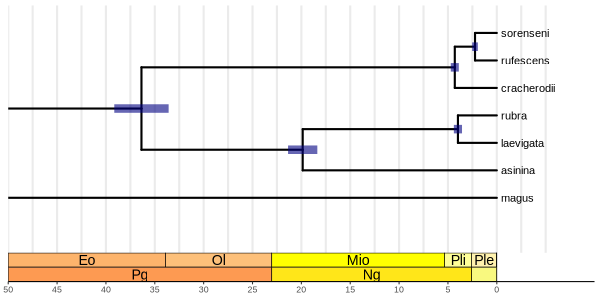

In [102]:
%%R -w 600 -h 300
library(ggtree)
library(deeptime)
library(phytools)

## Transformations
cur = treeio::read.mcmctree('BPP/FigTree_r1.tre')
cur@data$reltime = cur@data$reltime/(rate*1e6)
cur@phylo$edge.length = cur@phylo$edge.length/(rate*1e6)
cur@data$height_0.95_HPD = lapply(cur@data$height_0.95_HPD, function(pair){sapply(pair,function(BOUND){as.numeric(BOUND)/(rate*1e6)})})
print(cur@data$reltime)

## Plotting
p = ggtree(cur, size = 1) +
    theme_tree2() +
    theme(panel.grid.major.x = element_line(size = 1), panel.grid.minor.x = element_line(size = 1)) +
    geom_tiplab() +
    ggtree::geom_range('height_0.95_HPD', color='navy', alpha=.6, size=4)


timevec = c(100,95,90,85,80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5,0)
scaled_timevec = timevec*-1

p = revts(p) +
    coord_geo(neg = TRUE, xlim = c(-50,10), ylim = c(-1, Ntip(cur) + 1),
              pos = as.list(rep("bottom", 2)),
              dat = list('epochs','periods'), 
              height = list(unit(1, "lines"), unit(1, "lines")), center_end_labels = TRUE) +
    scale_x_continuous(breaks = scaled_timevec, labels = timevec) #+
    #coord_cartesian(clip = "off") +
print(p)

ggsave('mutation_figs/haliotis_tree.pdf',p,width = 6, height = 3)